In [1]:
import numpy as np
import pandas as pd
from darts import TimeSeries
from darts.utils.missing_values import fill_missing_values

from pytorch_lightning.callbacks import Callback
import torch
from darts.models import TCNModel

from pytorch_lightning.callbacks import Callback, EarlyStopping
from darts.metrics import marre
from optuna.integration import PyTorchLightningPruningCallback

import optuna

In [2]:
all_data = pd.read_csv("https://data.ecoforecast.org/neon4cast-targets/beetles/beetles-targets.csv.gz")
all_data["datetime"] = pd.to_datetime(all_data["datetime"]).dt.tz_localize(None)
stei_data_raw = all_data.loc[all_data["site_id"] == "STEI"]
tree_data_raw = all_data.loc[all_data["site_id"] == "TREE"]
unde_data_raw = all_data.loc[all_data["site_id"] == "UNDE"]

stei_data = stei_data_raw[["datetime", "site_id", "variable", "observation"]].pivot(index="datetime", columns="variable", values="observation")
tree_data = tree_data_raw[["datetime", "site_id", "variable", "observation"]].pivot(index="datetime", columns="variable", values="observation")
unde_data = unde_data_raw[["datetime", "site_id", "variable", "observation"]].pivot(index="datetime", columns="variable", values="observation")

stei_data.columns = ['abundance', 'richness']
tree_data.columns = ['abundance', 'richness']
unde_data.columns = ['abundance', 'richness']

In [3]:
stei_series = TimeSeries.from_dataframe(
    stei_data,
    freq = "D",
)

tree_series = TimeSeries.from_dataframe(
    tree_data,
    freq = "D",
)

unde_series = TimeSeries.from_dataframe(
    unde_data,
    freq = "D",
)

stei_series_filled = fill_missing_values(stei_series)
tree_series_filled = fill_missing_values(tree_series)
unde_series_filled = fill_missing_values(unde_series)

# Basic TCN

Optional parameters left at default (except for GPU use)

In [4]:
# from darts.models import TCNModel

# ab_val, ab_forecast = predict(
#     TCNModel, 
#     tree_series_filled[["abundance"]], 
#     frac=0.75, 
#     input_chunk_length = 365,
#     output_chunk_length = 300,
#     pl_trainer_kwargs = {"accelerator": "gpu", "devices": [0]},
#     kernel_size = 10,
#     num_filters = 10,
#     num_layers = 10,
#     n_epochs = 200,
# )
# ri_val, ri_forecast = predict(
#     TCNModel, 
#     tree_series_filled[["richness"]], 
#     frac=0.75,
#     input_chunk_length = 365,
#     output_chunk_length = 300,
#     pl_trainer_kwargs = {"accelerator": "gpu", "devices": [1]},
#     kernel_size = 10,
#     num_filters = 10,
#     num_layers = 10,
#     n_epochs = 200,
# )

In [5]:
# ab_val.plot()
# ab_forecast.plot()

In [6]:
# ri_val.plot()
# ri_forecast.plot()

### Hyperparameter tuning with Optuna

Following https://github.com/unit8co/darts/blob/master/examples/17-hyperparameter-optimization.ipynb

Logic: build a function that returns a metric for a fit model for a given set of hyperparameters (give as an input all hyperparameters to be optimized). Optuna will take the function as an input and tune hyperparameters, essentially.

Moreover, use a function that returns the fit model for more readability (as in link).

I will start with a much simpler example than the linked one.

For some reason, the notebook in the link sets the series as a global constant instead of being an input to functions. I'll start it this way and then try to migrate it to the function arguments and see if that works.

**Note:** running on the jupyter notebook was giving weird error messages related to IProgress. It apparently has something to do with the jupyter version having a bug, but I didn't get much clarity. I transferred the code to a python file which I ran from the terminal.

**Best values found**

*(optimizing for mse)*

- Best value: 0.0011712478962756792, 
    - Best params: {'input_chunk_length': 346, 'output_chunk_length': 230, 'kernel_size': 23, 'num_filters': 21, 'weight_norm': True, 'dilation_base': 2, 'dropout': 0.3696851887663041, 'lr': 0.0006057703116542806}
- Best value: 0.0013880039811830457,
    - Best params {'input_chunk_length': 339, 'output_chunk_length': 222, 'kernel_size': 18, 'num_filters': 23, 'weight_norm': False, 'dilation_base': 2, 'dropout': 0.31833372764419543, 'lr': 0.0001772871812814443} *(10 workers, reduced in/out chunk windows)*

*(optimizing for marre)*

In [7]:
_series = tree_series_filled[["abundance"]]

_train_frac = 0.85
_train, _val = _series.split_before(_train_frac)

In [8]:
def fit_model(
    in_len,
    out_len,
    kernel_size,
    num_filters,
    weight_norm,
    dilation_base,
    dropout,
    lr,
    likelihood=None,
    callbacks=None,
    gpu_devices = range(torch.cuda.device_count()),
):
    # train parameter is the training series
    
    # reproducibility
    torch.manual_seed(42)

    # some fixed parameters that will be the same for all models
    BATCH_SIZE = 1024
    MAX_N_EPOCHS = 250 # tuned hyperparameters with 70 epochs
    NR_EPOCHS_VAL_PERIOD = 1
    MAX_SAMPLES_PER_TS = 1000
    
    # throughout training we'll monitor the validation loss for early stopping
    early_stopper = EarlyStopping("train_loss", min_delta=0.0001, patience=5, verbose=True)
    if callbacks is None:
        callbacks = [early_stopper]
    else:
        callbacks = [early_stopper] + callbacks
    
    # detect if a GPU is available
    pl_trainer_kwargs = {
            "accelerator": "gpu",
            "devices": gpu_devices,
            "callbacks": callbacks,
        }
    num_workers = 4
    
    # if torch.cuda.is_available():
    #     pl_trainer_kwargs = {
    #         "accelerator": "gpu",
    #         "callbacks": callbacks,
    #     }
    #     num_workers = 4
    
    model = TCNModel(
        input_chunk_length=in_len,
        output_chunk_length=out_len,
        batch_size=BATCH_SIZE,
        n_epochs=MAX_N_EPOCHS,
        nr_epochs_val_period=NR_EPOCHS_VAL_PERIOD,
        kernel_size=kernel_size,
        num_filters=num_filters,
        weight_norm=weight_norm,
        dilation_base=dilation_base,
        dropout=dropout,
        optimizer_kwargs={"lr": lr},
        likelihood=likelihood,
        pl_trainer_kwargs=pl_trainer_kwargs,
        model_name="tcn_model",
        force_reset=True,
        save_checkpoints=True,
    )
    
    # fit model to train data
    model.fit(
        series = _train,
        max_samples_per_ts = MAX_SAMPLES_PER_TS,
        num_loader_workers = num_workers,
    )
    
    return model

In [9]:
d0 = {'input_chunk_length': 346, 'output_chunk_length': 230, 'kernel_size': 23, 'num_filters': 21, 'weight_norm': True, 'dilation_base': 2, 'dropout': 0.3696851887663041, 'lr': 0.0006057703116542806}

tuned_fit_TCNN0 = fit_model(
    in_len = d0['input_chunk_length'],
    out_len = d0['output_chunk_length'],
    kernel_size = d0['kernel_size'],
    num_filters = d0['num_filters'],
    weight_norm = d0['weight_norm'],
    dilation_base = d0['dilation_base'],
    dropout = d0['dropout'],
    lr = d0['lr'],
    gpu_devices = [0],
)

/home/rstudio/.local/lib/python3.10/site-packages/torch/random.py:107: UserWarning: CUDA reports that you have 2 available devices, and you have used fork_rng without explicitly specifying which devices are being used. For safety, we initialize *every* CUDA device by default, which can be quite slow if you have a lot of GPUs.  If you know that you are only making use of a few CUDA devices, set the environment variable CUDA_VISIBLE_DEVICES or the 'devices' keyword argument of fork_rng with the set of devices you are actually using.  For example, if you are using CPU only, set CUDA_VISIBLE_DEVICES= or devices=[]; if you are using GPU 0 only, set CUDA_VISIBLE_DEVICES=0 or devices=[0].  To initialize all devices and suppress this warning, set the 'devices' keyword argument to `range(torch.cuda.device_count())`.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 

Training: 0it [00:00, ?it/s]

Metric train_loss improved. New best score: 0.108
/home/rstudio/.local/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:359: UserWarning: `ModelCheckpoint(monitor='val_loss')` could not find the monitored key in the returned metrics: ['train_loss', 'epoch', 'step']. HINT: Did you call `log('val_loss', value)` in the `LightningModule`?
  warning_cache.warn(m)
Metric train_loss improved by 0.022 >= min_delta = 0.0001. New best score: 0.087
Metric train_loss improved by 0.026 >= min_delta = 0.0001. New best score: 0.061
Metric train_loss improved by 0.019 >= min_delta = 0.0001. New best score: 0.042
Metric train_loss improved by 0.004 >= min_delta = 0.0001. New best score: 0.038
Metric train_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.037
Metric train_loss improved by 0.003 >= min_delta = 0.0001. New best score: 0.035
Metric train_loss improved by 0.003 >= min_delta = 0.0001. New best score: 0.031
Metric train_loss improved by 0.002 >= min_d

In [10]:
forecast0 = tuned_fit_TCNN0.predict(len(_val))

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

In [11]:
d1 = {'input_chunk_length': 339, 'output_chunk_length': 222, 'kernel_size': 18, 'num_filters': 23, 'weight_norm': False, 'dilation_base': 2, 'dropout': 0.31833372764419543, 'lr': 0.0001772871812814443}

tuned_fit_TCNN1 = fit_model(
    in_len = d1['input_chunk_length'],
    out_len = d1['output_chunk_length'],
    kernel_size = d1['kernel_size'],
    num_filters = d1['num_filters'],
    weight_norm = d1['weight_norm'],
    dilation_base = d1['dilation_base'],
    dropout = d1['dropout'],
    lr = d1['lr'],
    gpu_devices = [0],
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name          | Type              | Params
----------------------------------------------------
0 | criterion     | MSELoss           | 0     
1 | train_metrics | MetricCollection  | 0     
2 | val_metrics   | MetricCollection  | 0     
3 | dropout       | MonteCarloDropout | 0     
4 | res_blocks    | ModuleList        | 58.2 K
----------------------------------------------------
58.2 K    Trainable params
0         Non-trainable params
58.2 K    Total params
0.233     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Metric train_loss improved. New best score: 0.181
Metric train_loss improved by 0.054 >= min_delta = 0.0001. New best score: 0.126
Metric train_loss improved by 0.041 >= min_delta = 0.0001. New best score: 0.086
Metric train_loss improved by 0.025 >= min_delta = 0.0001. New best score: 0.061
Metric train_loss improved by 0.007 >= min_delta = 0.0001. New best score: 0.053
Monitored metric train_loss did not improve in the last 5 records. Best score: 0.053. Signaling Trainer to stop.


In [12]:
forecast1 = tuned_fit_TCNN1.predict(len(_val))

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

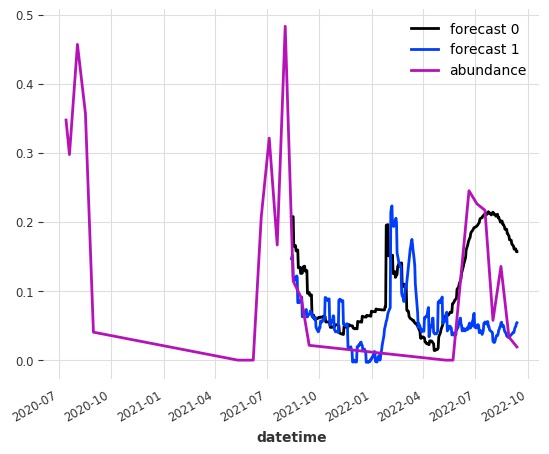

In [13]:
forecast0 = tuned_fit_TCNN0.predict(len(_val))
forecast1 = tuned_fit_TCNN1.predict(len(_val))

forecast0.plot(label = "forecast 0")
forecast1.plot(label = "forecast 1")

dont_plot, plot_series = _series.split_before(2*_train_frac - 1)
plot_series.plot()

## Generalizing to other series

In [14]:
_series = tree_series_filled[["abundance"]]

_train_frac = 0.80
_train, _val = _series.split_before(_train_frac)

In [15]:
d0 = {'input_chunk_length': 346, 'output_chunk_length': 230, 'kernel_size': 23, 'num_filters': 21, 'weight_norm': True, 'dilation_base': 2, 'dropout': 0.3696851887663041, 'lr': 0.0006057703116542806}

tuned_fit_TCNN0 = fit_model(
    in_len = d0['input_chunk_length'],
    out_len = d0['output_chunk_length'],
    kernel_size = d0['kernel_size'],
    num_filters = d0['num_filters'],
    weight_norm = d0['weight_norm'],
    dilation_base = d0['dilation_base'],
    dropout = d0['dropout'],
    lr = d0['lr'],
    gpu_devices = [0],
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name          | Type              | Params
----------------------------------------------------
0 | criterion     | MSELoss           | 0     
1 | train_metrics | MetricCollection  | 0     
2 | val_metrics   | MetricCollection  | 0     
3 | dropout       | MonteCarloDropout | 0     
4 | res_blocks    | ModuleList        | 62.2 K
----------------------------------------------------
62.2 K    Trainable params
0         Non-trainable params
62.2 K    Total params
0.249     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Metric train_loss improved. New best score: 0.263
Metric train_loss improved by 0.169 >= min_delta = 0.0001. New best score: 0.094
Metric train_loss improved by 0.005 >= min_delta = 0.0001. New best score: 0.088
Metric train_loss improved by 0.026 >= min_delta = 0.0001. New best score: 0.062
Metric train_loss improved by 0.003 >= min_delta = 0.0001. New best score: 0.060
Metric train_loss improved by 0.002 >= min_delta = 0.0001. New best score: 0.057
Metric train_loss improved by 0.007 >= min_delta = 0.0001. New best score: 0.050
Metric train_loss improved by 0.007 >= min_delta = 0.0001. New best score: 0.044
Metric train_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.043
Metric train_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.043
Metric train_loss improved by 0.003 >= min_delta = 0.0001. New best score: 0.040
Metric train_loss improved by 0.003 >= min_delta = 0.0001. New best score: 0.036
Metric train_loss improved by 0.001 >= min_delta = 0.0001. 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

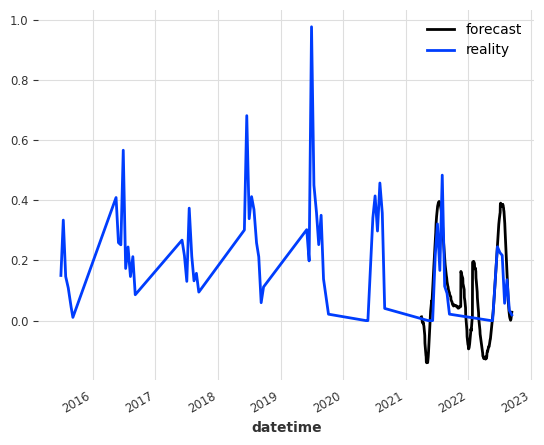

In [16]:
forecast0_stei = tuned_fit_TCNN0.predict(len(_val))
forecast0_stei.plot(label = "forecast")
_series.plot(label = "reality")

## Remember after coffee:

GPU1.py running on terminal 5, GPU.py (GPU[0]) running on terminal 6 (using marre)

In [17]:
forecast0_stei.components

Index(['abundance'], dtype='object', name='component')

In [18]:
def predict(model_class, series, past_covariates = None, lag_past_covariates = None, frac = 0.85, *args, **kwargs):
    """
    model:  forecasting model class
    series: full data set (to be divided into fitting data, and validation data)
    frac:   fraction of training data to full data
    *args, **kwargs: additional parameters of the model
    """
    model = model_class(*args, **kwargs)
    train, val = series.split_before(frac)
    
    print(f"Fitting {model_class}")
    if past_covariates is not None:
        model.fit(train, past_covariates = past_covariates)
    else:    
        model.fit(train)
    forecast = model.predict(len(val))
    return val, forecast